In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error
from numpy import array

In [2]:
stockPrices = pd.read_csv('yahooScrapping/AAPL.csv', index_col="Date")

In [3]:
testRatio = 0.2
trainingRatio = 1 - testRatio

trainingSize = int(trainingRatio * len(stockPrices))
testSize = int(testRatio * len(stockPrices))
print(f"Training Size: {trainingSize}")
print(f"Testing Size: {testSize}")

train = stockPrices[:trainingSize][["Close"]]  # Ensure train is a DataFrame
test = stockPrices[trainingSize:][["Close"]].copy()  # Ensure test is a DataFrame

Training Size: 4918
Testing Size: 1229


In [6]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)


In [7]:
# Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i - N: i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [8]:
# Calculate the metrics RMSE and MAPE
def calculateRMSE(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def calculateMAPE(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [9]:
# Define LSTM model
def Run_LSTM(X_train, y_train, layer_units=50, cur_epochs=15, cur_batch_size=20):
    inp = Input(shape=(X_train.shape[1], 1))
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inputs=inp, outputs=out)

    model.compile(loss="mean_squared_error", optimizer="adam")

    history = model.fit(
        X_train,
        y_train,
        epochs=cur_epochs,
        batch_size=cur_batch_size,
        verbose=1,
        validation_split=0.1,
        shuffle=True
    )

    return model, history


In [12]:
# Suppress the UserWarning from StandardScaler
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockPrices[["Close"]])
scaled_data_train = scaled_data[:train.shape[0]]

window_size = 50  # define window_size variable
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

model, history = Run_LSTM(X_train, y_train, layer_units=50)

Epoch 1/15
220/220 [==============================] - 12s 20ms/step - loss: 0.0092 - val_loss: 0.0028
Epoch 2/15
220/220 [==============================] - 3s 15ms/step - loss: 9.0347e-05 - val_loss: 0.0019
Epoch 3/15
220/220 [==============================] - 3s 15ms/step - loss: 8.7210e-05 - val_loss: 0.0016
Epoch 4/15
220/220 [==============================] - 3s 15ms/step - loss: 8.5531e-05 - val_loss: 0.0015
Epoch 5/15
220/220 [==============================] - 3s 15ms/step - loss: 8.3819e-05 - val_loss: 0.0014
Epoch 6/15
220/220 [==============================] - 4s 16ms/step - loss: 8.1136e-05 - val_loss: 0.0014
Epoch 7/15
220/220 [==============================] - 3s 16ms/step - loss: 8.8376e-05 - val_loss: 0.0011
Epoch 8/15
220/220 [==============================] - 3s 15ms/step - loss: 7.6582e-05 - val_loss: 0.0013
Epoch 9/15
220/220 [==============================] - 3s 15ms/step - loss: 7.9414e-05 - val_loss: 9.8296e-04
Epoch 10/15
220/220 [==============================] -

In [13]:
# Preprocess test data
def preprocess_testdat(data=stockPrices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1, 1)
    raw = scaler.transform(raw)

    X_test = [raw[i - window_size: i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Ensure test DataFrame has a column to store predictions
test["Predictions_lstm"] = predicted_price

39/39 [==============================] - 1s 8ms/step


In [14]:
# Debugging output
print(test.head())
print(test.columns)

                               Close  Predictions_lstm
Date                                                  
2019-07-23 00:00:00-04:00  50.387718         48.515728
2019-07-24 00:00:00-04:00  50.346718         48.634930
2019-07-25 00:00:00-04:00  49.948612         48.774757
2019-07-26 00:00:00-04:00  50.122326         48.894753
2019-07-29 00:00:00-04:00  50.590393         49.003963
Index(['Close', 'Predictions_lstm'], dtype='object')


In [15]:
# Evaluate performance
rmse_lstm = calculateRMSE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculateMAPE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

print(f"RMSE for LSTM: {rmse_lstm}")
print(f"MAPE for LSTM: {mape_lstm}")

RMSE for LSTM: 34.30980652102644
MAPE for LSTM: 18.93897467414003


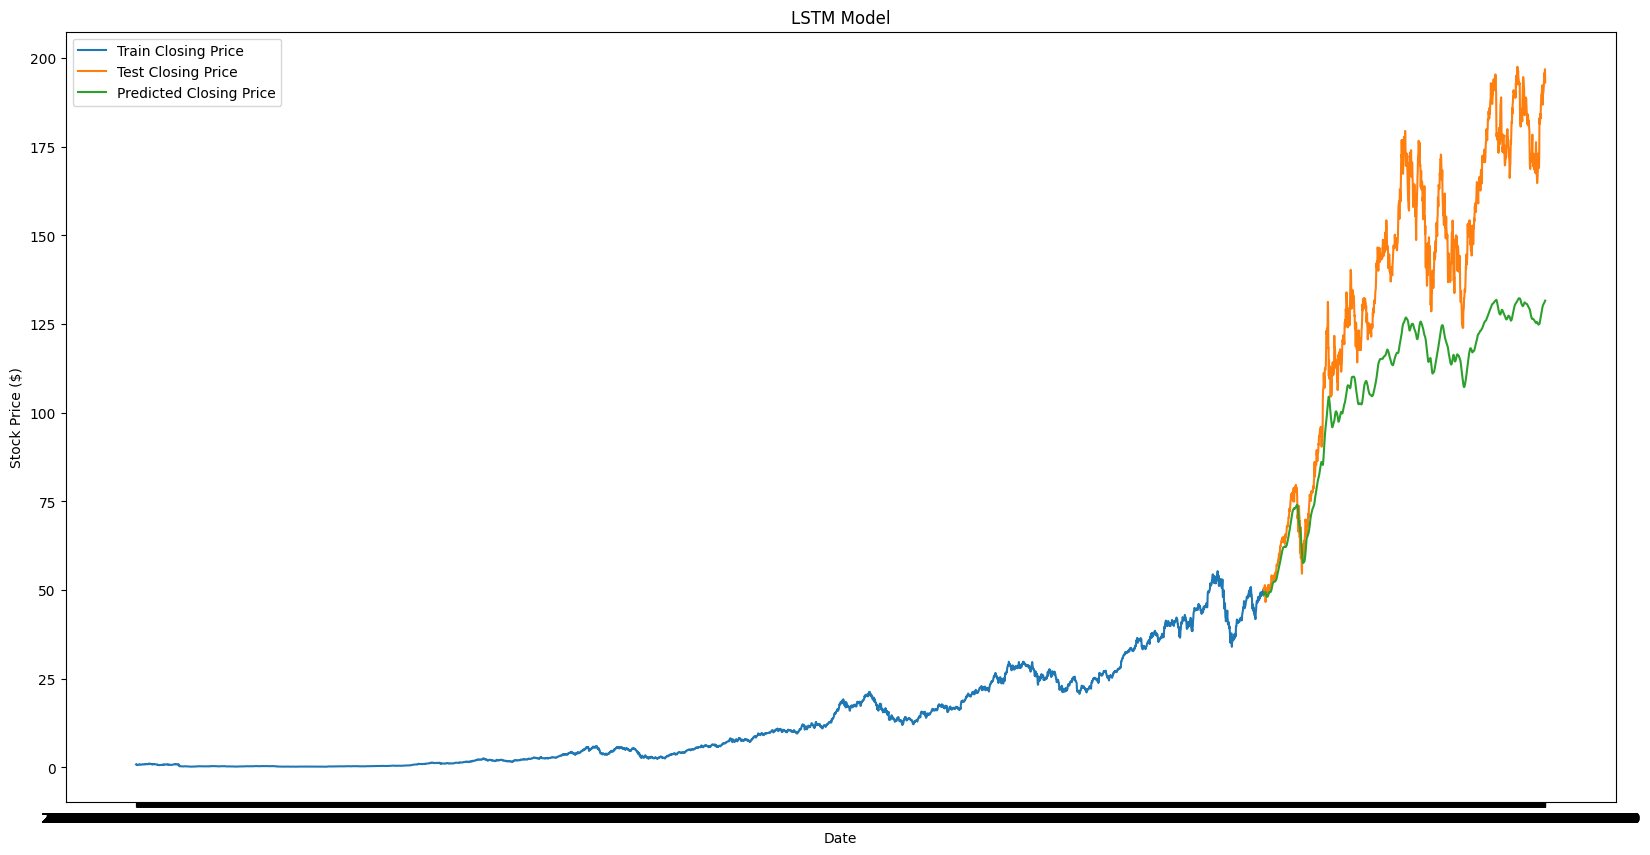

In [16]:
# Plot predicted vs actual closing price
def plot_stock_trend_lstm(train, test):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(train.index, train["Close"], label="Train Closing Price")
    ax.plot(test.index, test["Close"], label="Test Closing Price")
    ax.plot(test.index, test["Predictions_lstm"], label="Predicted Closing Price")
    ax.set_title("LSTM Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price ($)")
    ax.legend()
    plt.show()

plot_stock_trend_lstm(train, test)